#Forecasting spot electricity prices: Deep learning approaches and empirical comparison of traditional algorithms

Deep Learning methods:
1. A DNN as an extension to the traditional MLP.
2. A hybrid LSTM-DNN structure.
3. A hybrid GRU-DNN structure.
4. A CNN model.

Other benchmark models for electricy price forecasting.

Performance metrics: sMAPE (symmetric mean absolute percentage error).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate, GRU, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Flatten, concatenate
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam, schedules
from tensorflow.keras.initializers import HeNormal
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from sklearn.svm import SVR
import time
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore, boxcox
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

#Data
Prices of Belgium, with generation forecast and system load forecast

In [51]:
file_path = 'BE.csv'
df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)# Load the dataset

print(df.head())

                  Date   Prices   Generation forecast   System load forecast
0  2011-01-09 00:00:00    32.54               63065.0                63000.0
1  2011-01-09 01:00:00    21.55               62715.0                58800.0
2  2011-01-09 02:00:00    15.71               61952.0                58500.0
3  2011-01-09 03:00:00    10.58               59262.0                54300.0
4  2011-01-09 04:00:00    10.32               56883.0                51900.0


### Pre-processing: outliers

In [53]:
# Select only numeric columns from the DataFrame
df_numeric = df.select_dtypes(include=[np.number])

# Calculate Z-scores
z_scores = np.abs(zscore(df_numeric))
threshold = 3 # threshold for considering a value as an outlier

# Replace outliers with the median of the column
df_cleaned = df_numeric.mask(z_scores > threshold, df_numeric.median(), axis=1)
df[df_numeric.columns] = df_cleaned

### Training, validation and test set

In [54]:
# Define the split dates
start_date = '2011-01-09'
val_start = '2015-04-01'
test_start = '2016-02-15'

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.columns = df.columns.str.strip()

# Filter the dataset based on the date ranges
train_df = df[(df['Date'] >= start_date) & (df['Date'] < val_start)]
val_df = df[(df['Date'] >= val_start) & (df['Date'] < test_start)]
test_df = df[(df['Date'] >= test_start)]

train_df.set_index('Date', inplace=True)
val_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)


# Display the results
print("Training set:")
print(train_df)

print("\nValidation set:")
print(val_df)

print("\nTest set:")
print(test_df)

Training set:
                     Prices  Generation forecast  System load forecast
Date                                                                  
2011-01-09 00:00:00   32.54              63065.0               63000.0
2011-01-09 01:00:00   21.55              62715.0               58800.0
2011-01-09 02:00:00   15.71              61952.0               58500.0
2011-01-09 03:00:00   10.58              59262.0               54300.0
2011-01-09 04:00:00   10.32              56883.0               51900.0
...                     ...                  ...                   ...
2015-03-31 19:00:00   49.69              69195.0               58902.0
2015-03-31 20:00:00   53.62              69539.0               58748.0
2015-03-31 21:00:00   48.91              68972.0               59440.0
2015-03-31 22:00:00   47.02              67632.0               56156.0
2015-03-31 23:00:00   41.50              67361.0               59102.0

[37032 rows x 3 columns]

Validation set:
                    

# sMAPE
Accuracy sMAPE = symmetric mean absolute percentage error

In [55]:
def smape(y_true, y_pred):
    numerator = tf.abs(y_pred - y_true)
    denominator = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0
    return tf.reduce_mean(numerator / (denominator)) * 100

#Deep Learning models:


##DNN model

In [ ]:
n1DNN = 239 # first hidden layer neurons
n2DNN = 162 # second hidden layer neurons
activationFunctionDNN = 'relu'
n_hours = 24
hours = range(n_hours)

### X - input

I consider as input features:
*   the day of the week of *D* (0 monday,...)
*   the price of the previous day *D-1* for each hour (24)
*   the price of the 2 previous day *D-2* for each hour (24)
*   the price of the previous week *D-7* for each hour (24)
*   the generation forecast of the day *D* (24)
*   the load forecast of the day *D* (24)





In [ ]:
n_features = 1+ 24 + 24 + 24 + 24 + 24
print(n_features)

121


In [ ]:
# Define columns (date is the index)
columns = ['Day'] + [f'Price_D-1_h{hour}' for hour in hours] + \
          [f'Price_D-2_h{hour}' for hour in hours] + \
          [f'Price_D-7_h{hour}' for hour in hours] + \
          [f'Generation_D_h{hour}' for hour in hours] + \
          [f'Load_D_h{hour}' for hour in hours]

In [ ]:
train_df.index = pd.to_datetime(train_df.index)
val_df.index = pd.to_datetime(val_df.index)
test_df.index = pd.to_datetime(test_df.index)

In [ ]:
train_df.index = train_df.index.round('S')
test_df.index = test_df.index.round('S')
val_df.index = val_df.index.round('S')

In [ ]:
indexTrain = train_df.iloc[24:,:].loc[train_df.index[0] + pd.Timedelta(weeks=1):].index
indexTest = test_df.iloc[24:,:].loc[test_df.index[0] + pd.Timedelta(weeks=1) :].index
indexVal = val_df.iloc[24:,:].loc[val_df.index[0] + pd.Timedelta(weeks=1):].index

predDatesTrain = indexTrain[::24]
predDatesVal = indexVal[::24]
predDatesTest = indexTest[::24]

# I create dataframe where the index is the time where a prediction is made and the columns is the horizons of the prediction
indexTrain = pd.DataFrame(index=predDatesTrain, columns=['h' + str(hour) for hour in range(24)])
indexVal = pd.DataFrame(index=predDatesVal, columns=['h' + str(hour) for hour in range(24)])
indexTest = pd.DataFrame(index=predDatesTest, columns=['h' + str(hour) for hour in range(24)])

for hour in range(24):
  indexTrain.loc[:, 'h' + str(hour)] = indexTrain.index + pd.Timedelta(hours=hour)
  indexVal.loc[:, 'h' + str(hour)] = indexVal.index + pd.Timedelta(hours=hour)
  indexTest.loc[:, 'h' + str(hour)] = indexTest.index + pd.Timedelta(hours=hour)

# Preallocating in memory the X and Y arrays
Xtrain = np.zeros([indexTrain.shape[0], n_features])
Ytrain = np.zeros([indexTrain.shape[0], n_hours])
Xval = np.zeros([indexVal.shape[0], n_features])
Yval = np.zeros([indexVal.shape[0], n_hours])
Xtest = np.zeros([indexTest.shape[0], n_features])
Ytest = np.zeros([indexTest.shape[0], n_hours])

indexFeatures = 0

# Adding the day of the week as a feature if needed
# For training, I assume the day of the week is a continuous variable.
# So monday at 00 is 1. Monday at 1h is 1.04, Tuesday at 2h is 2.08, etc.
Xtrain[:, 0] = indexTrain.index.dayofweek + indexTrain.index.hour / 24
Xval[:, 0] = indexVal.index.dayofweek + indexVal.index.hour / 24
Xtest[:, 0] = indexTest.index.dayofweek
indexFeatures += 1

# price D-1
for past_day in [1, 2, 7]:
  for hour in range(24): # For each possible horizon
        # I define the corresponding past time indexs
        pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values) - pd.Timedelta(hours=24*past_day)
        pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)  - pd.Timedelta(hours=24*past_day)
        pastIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values) - pd.Timedelta(hours=24*past_day)

        # price D-1
        Xtrain[:, indexFeatures] = train_df.loc[pastIndexTrain, 'Prices']
        Xtest[:, indexFeatures] = test_df.loc[pastIndexTest, 'Prices']
        Xval[:, indexFeatures] = val_df.loc[pastIndexVal, 'Prices']
        indexFeatures += 1


# Adding generation inputs at day D
for hour in range(24):
    past_day = 1
    # define the corresponding future index at time D
    futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
    futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
    futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

    Xtrain[:, indexFeatures] = train_df.loc[futureIndexTrain, 'Generation forecast']
    Xval[:, indexFeatures] = val_df.loc[futureIndexVal, 'Generation forecast']
    Xtest[:, indexFeatures] = test_df.loc[futureIndexTest, 'Generation forecast']
    indexFeatures += 1


# adding load inputs at day D
for hour in range(24):
    past_day = 1
    # define the corresponding future index at time D
    futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
    futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
    futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

    # Adding Load inputs at day D
    Xtrain[:, indexFeatures] = train_df.loc[futureIndexTrain, 'System load forecast']
    Xval[:, indexFeatures] = val_df.loc[futureIndexVal, 'System load forecast']
    Xtest[:, indexFeatures] = test_df.loc[futureIndexTest, 'System load forecast']
    indexFeatures += 1


### Y - target

In [ ]:
# Extracting the predicted values Y
for hour in range(24):
  futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
  futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
  futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

  Ytrain[:, hour] = train_df.loc[futureIndexTrain, 'Prices']
  Yval[:,hour] = val_df.loc[futureIndexVal, 'Prices']
  Ytest[:, hour] = test_df.loc[futureIndexTest, 'Prices']

indexTest = indexTest.index

### Data Normalization
Data preprocessing step: the data is normalized to the intervals [-1, 1]

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))

Xtrain_scaled = scaler.fit_transform(Xtrain)
Xval_scaled = scaler.transform(Xval)
Xtest_scaled = scaler.transform(Xtest)

y_scaler = MinMaxScaler(feature_range=(-1, 1))
Ytrain = y_scaler.fit_transform(Ytrain)
Yval = y_scaler.transform(Yval)

### Model

In [ ]:
model = Sequential([
    Dense(n1DNN, activation=activationFunctionDNN, input_shape=(n_features,)),
    Dense(n2DNN, activation=activationFunctionDNN),
    Dense(n_hours)
])
# Compile the model with Mean Absolute Error as the Loss function
opt = Adam(learning_rate = 1e-5)
model.compile(optimizer=opt, loss='mean_absolute_error')  #, metrics=[smape])

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 239)                 │          29,158 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 162)                 │          38,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 24)                  │           3,912 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,950 (281.05 KB)

 Trainable params: 71,950 (281.05 KB)

 Non-trainable params: 0 (0.00 B)

### Training DNN model

In [ ]:
# Early stopping configuration
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3027 - val_loss: 0.3341
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2920 - val_loss: 0.3249
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2822 - val_loss: 0.3163
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2731 - val_loss: 0.3083
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2646 - val_loss: 0.3007
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2567 - val_loss: 0.2934
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2493 - val_loss: 0.2864
Epoch 8/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2422 - val_loss: 0.2796
Epoch 9/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2355 - val_loss: 0.2731
Epoch 10/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2292 - val_loss: 0.2667
Epoch 11/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2233 - val_loss: 0.2606
Epoch 12/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

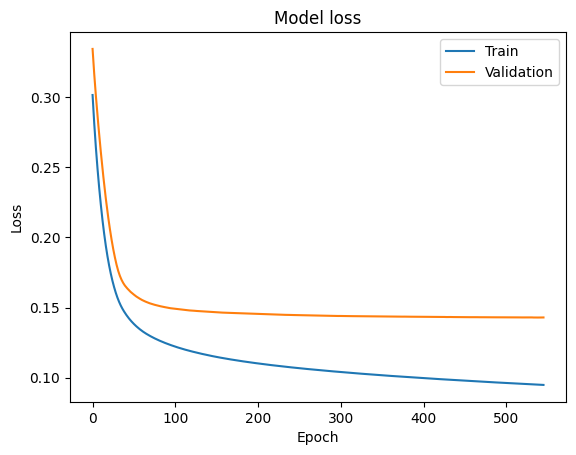

In [ ]:
# Train the model
history = model.fit(Xtrain_scaled, Ytrain,
                    epochs=1000,
                    batch_size=64,
                    validation_data=(Xval_scaled, Yval),
                    shuffle = True,
                    callbacks=[early_stopping])

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

The loss and smape refer to training set, while val_loss and val_smape refer to validation set.

It stops before, due to the early stopping.

### Prediction and sMAPE:
Performance evaluation of DNN model on test set

In [ ]:
Yp = model.predict(Xtest_scaled, verbose=0).squeeze()
Yp = y_scaler.inverse_transform(Yp).squeeze()

# To print some predicted values
results = pd.DataFrame({
    'Valori Attesi': Ytest.flatten(),
    'Predizioni': Yp.flatten()
})

print(results.head(20))

# Calculate and print the metrics
smape_value = smape(tf.cast(Ytest, dtype=tf.float64), tf.cast(Yp, dtype=tf.float64))
print(f'sMAPE: {smape_value:.2f}%')

    Valori Attesi  Predizioni
0            7.72   13.831306
1            8.35    8.466706
2            7.15   11.236300
3            4.97    3.315855
4            5.39    4.164815
5            8.38    8.306069
6           18.05   22.706499
7           26.38   38.279140
8           27.92   38.789413
9           31.97   41.816132
10          32.96   38.793087
11          29.76   39.968140
12          27.53   46.327732
13          24.52   39.292965
14          23.98   38.132641
15          23.91   34.156353
16          23.92   38.273258
17          27.93   41.376175
18          40.13   54.990059
19          39.45   51.598274
sMAPE: 16.28%


##LSTM-DNN model

In [106]:
activationFunctionDNN = 'relu'
activationFunctionLSTM = 'tanh'
nDNN = 184
nLSTM = 83
sequenceLength = 336  #hours for 2 weeks
n_hours = 24
hours = range(n_hours)

timesteps = sequenceLength  # 2 weeks of hourly data

###X_F - day-ahead input
Data: are divided into:
*   Future information (X_F)
*   A collection of input sequence, each one representing past information (X_S)



In [107]:
columns_X_F = ['Day'] +  \
          [f'Generation_D_h{hour}' for hour in hours] + \
          [f'Load_D_h{hour}' for hour in hours]

n_features_F = len(columns_X_F)

In [108]:
indexTrain = train_df.iloc[24:,:].loc[train_df.index[0] :].index
indexTest = test_df.iloc[24:,:].loc[test_df.index[0] :].index
indexVal = val_df.iloc[24:,:].loc[val_df.index[0] :].index

predDatesTrain = indexTrain[::24]
predDatesVal = indexVal[::24]
predDatesTest = indexTest[::24]

# I create dataframe where the index is the time where a prediction is made and the columns is the horizons of the prediction
indexTrain = pd.DataFrame(index=predDatesTrain, columns=['h' + str(hour) for hour in range(24)])
indexVal = pd.DataFrame(index=predDatesVal, columns=['h' + str(hour) for hour in range(24)])
indexTest = pd.DataFrame(index=predDatesTest, columns=['h' + str(hour) for hour in range(24)])

for hour in range(24):
  indexTrain.loc[:, 'h' + str(hour)] = indexTrain.index + pd.Timedelta(hours=hour)
  indexVal.loc[:, 'h' + str(hour)] = indexVal.index + pd.Timedelta(hours=hour)
  indexTest.loc[:, 'h' + str(hour)] = indexTest.index + pd.Timedelta(hours=hour)

# Preallocating in memory the X and Y arrays
X_F_train = np.zeros([indexTrain.shape[0], n_features_F])
Ytrain = np.zeros([indexTrain.shape[0], n_hours])
X_F_val = np.zeros([indexVal.shape[0], n_features_F])
Yval = np.zeros([indexVal.shape[0], n_hours])
X_F_test = np.zeros([indexTest.shape[0], n_features_F])
Ytest = np.zeros([indexTest.shape[0], n_hours])

indexFeatures_F = 0


# Adding the day of the week as a feature
X_F_train[:, 0] = indexTrain.index.dayofweek
X_F_val[:, 0] = indexVal.index.dayofweek
X_F_test[:, 0] = indexTest.index.dayofweek
indexFeatures_F += 1


# Adding generation inputs at day D
for hour in range(24):
    past_day = 1
    #define the corresponding future index at time D
    futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
    futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
    futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

    X_F_train[:, indexFeatures_F] = train_df.loc[futureIndexTrain, 'Generation forecast']
    X_F_val[:, indexFeatures_F] = val_df.loc[futureIndexVal, 'Generation forecast']
    X_F_test[:, indexFeatures_F] = test_df.loc[futureIndexTest, 'Generation forecast']
    indexFeatures_F += 1


#adding load inputs at day D
for hour in range(24):
    past_day = 1
    #define the corresponding future index at time D
    futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
    futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
    futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

    # Adding Load inputs at day D
    X_F_train[:, indexFeatures_F] = train_df.loc[futureIndexTrain, 'System load forecast']
    X_F_val[:, indexFeatures_F] = val_df.loc[futureIndexVal, 'System load forecast']
    X_F_test[:, indexFeatures_F] = test_df.loc[futureIndexTest, 'System load forecast']
    indexFeatures_F += 1

In [109]:
print(X_F_train.shape) # from 10/01/2011
print(X_F_val.shape)
print(X_F_test.shape)

(1542, 49)
(319, 49)
(320, 49)


### Y - target

In [110]:
# Extracting the predicted values Y
for hour in range(24):
  futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
  futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
  futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

  Ytrain[:, hour] = train_df.loc[futureIndexTrain, 'Prices']
  Yval[:,hour] = val_df.loc[futureIndexVal, 'Prices']
  Ytest[:, hour] = test_df.loc[futureIndexTest, 'Prices']

indexTest = indexTest.index

In [111]:
print(Ytrain.shape)
print(Yval.shape)
print(Ytest.shape)

(1542, 24)
(319, 24)
(320, 24)


### X_S - past informations

In [112]:
#past information (collection of past values) = sequential inputs --> LSTM
#group by timesteps
def create_sequences(data, steps):
    X = []
    for i in range(steps, len(data), n_hours):
      X.append(data.iloc[i-steps:i].values)
    return np.array(X)

# Creazione di X_S per il training, validation e test set
X_S_train = create_sequences(train_df[['Prices']], timesteps) #start from 23/01/211 to 31/12/2014
X_S_val = create_sequences(val_df[['Prices']], timesteps)
X_S_test = create_sequences(test_df[['Prices']], timesteps)

print(X_S_train.shape)
print(X_S_val.shape)
print(X_S_test.shape)

(1529, 336, 1)
(306, 336, 1)
(307, 336, 1)


The size of X_S, X_F and Y have to match:

In [113]:
X_F_train = X_F_train[13:]   # Remove the first 13 days
X_F_val = X_F_val[13:]
X_F_test = X_F_test[13:]
Ytrain = Ytrain[13:]   # Remove the first 13 days
Yval = Yval[13:]
Ytest = Ytest[13:]
print(X_F_train.shape)
print(X_F_val.shape)
print(X_F_test.shape)
print(Ytrain.shape)
print(Yval.shape)
print(Ytest.shape)

(1529, 49)
(306, 49)
(307, 49)
(1529, 24)
(306, 24)
(307, 24)


In [114]:
x_seq_num_features = X_S_train.shape[2]
x_non_seq_num_features = X_F_train.shape[1]
print(x_seq_num_features)
print(x_non_seq_num_features)

1
49


### Data Normalization

In [115]:
# Scale X_F
scaler_F = MinMaxScaler(feature_range=(-1, 1))
X_F_train = scaler_F.fit_transform(X_F_train)
X_F_val = scaler_F.transform(X_F_val)
X_F_test = scaler_F.transform(X_F_test)

# Scale X_S
scale_S = MinMaxScaler(feature_range=(-1, 1))
X_S_train = scale_S.fit_transform(X_S_train.reshape(-1, x_seq_num_features)).reshape(X_S_train.shape)
X_S_val = scale_S.transform(X_S_val.reshape(-1, x_seq_num_features)).reshape(X_S_val.shape)
X_S_test = scale_S.transform(X_S_test.reshape(-1, x_seq_num_features)).reshape(X_S_test.shape)

# Scale the target values
y_scaler = MinMaxScaler(feature_range=(-1, 1))
Ytrain = y_scaler.fit_transform(Ytrain)
Yval = y_scaler.transform(Yval)

### Model

In [116]:
#sequential input for LSTM
seq_input = Input(shape=(timesteps, x_seq_num_features), name = 'sequential_input')
lstm_out = LSTM(units=nLSTM, activation=activationFunctionLSTM, return_sequences=False, name = 'lstm')(seq_input)

# Non-sequential input for DNN
non_seq_input = Input(shape=(x_non_seq_num_features,), name='non_sequential_input')  # Number of non-sequential features
dnn_out = Dense(units=nDNN, activation=activationFunctionDNN, name='DNN')(non_seq_input)

# Concatenate the outputs of LSTM and DNN
concat = Concatenate(name = 'concat')([lstm_out, dnn_out])

# Output layer
out = Dense(units=n_hours, activation = 'linear', name = 'output')(concat)

# Build the model
model = Model(inputs=[seq_input, non_seq_input], outputs=out)

# Compile the model
#opt = Adam(learning_rate = 1e-4)
model.compile(optimizer='adam', loss='mean_absolute_error')

# Model summary
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequential_input          │ (None, 336, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ non_sequential_input      │ (None, 49)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 83)             │         28,220 │ sequential_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DNN (Dense)               │ (None, 184)            │          9,200 │ non_sequential_input[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat (Concatenate)      │ (None, 267)            │              0 │ lstm[0][0], DNN[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 24)             │          6,432 │ concat[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 43,852 (171.30 KB)

 Trainable params: 43,852 (171.30 KB)

 Non-trainable params: 0 (0.00 B)

### Training LSTM-DNN model

In [117]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss',  factor=0.6, patience=12, min_lr=1e-6)

Epoch 1/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 512ms/step - loss: 0.2564 - val_loss: 0.2037 - learning_rate: 0.0010
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 661ms/step - loss: 0.1734 - val_loss: 0.1721 - learning_rate: 0.0010
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 487ms/step - loss: 0.1415 - val_loss: 0.1645 - learning_rate: 0.0010
Epoch 4/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 488ms/step - loss: 0.1322 - val_loss: 0.1577 - learning_rate: 0.0010
Epoch 5/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 583ms/step - loss: 0.1279 - val_loss: 0.1525 - learning_rate: 0.0010
Epoch 6/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 667ms/step - loss: 0.1247 - val_loss: 0.1530 - learning_rate: 0.0010
Epoch 7/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 484ms/step - loss: 0.1228 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 8/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 666ms/step - loss: 0.1217 - val_loss: 0.1505 - learning_rate: 0.0010
Epoch 9/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 515ms/step - loss: 0.1204 - val_loss: 0.1493 - learning_ra

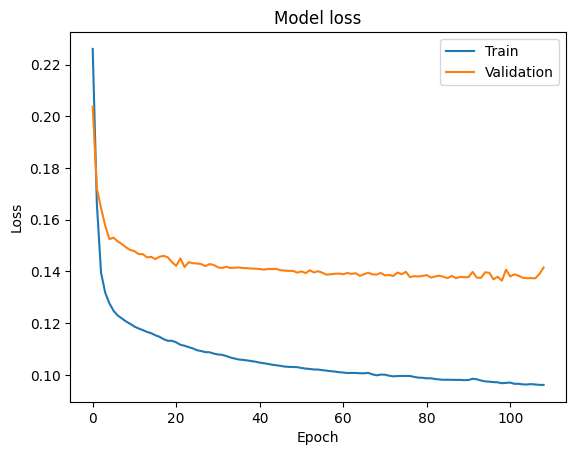

In [118]:
#training the model
history = model.fit([X_S_train, X_F_train], # sequential and non-sequential inputs
                    [Ytrain],
                    validation_data=([X_S_val, X_F_val], Yval),
                    epochs=1000,
                    batch_size=128,
                    shuffle=True,
                    callbacks=[early_stopping, lr_schedule]
)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Prediction and sMAPE
Performance evaluation of the hybrid LSTM-DNN model on the test set

In [119]:
Yp = model.predict([X_S_test, X_F_test], verbose=0).squeeze()
Yp = y_scaler.inverse_transform(Yp).squeeze()

results = pd.DataFrame({
    'Valori Attesi': Ytest.flatten(),
    'Predizioni': Yp.flatten()
})

print(results.head(20))

# Calculate and print the metrics
smape_value = smape(tf.cast(Ytest, dtype=tf.float64), tf.cast(Yp, dtype=tf.float64))
print(f'sMAPE: {smape_value:.2f}%')

    Valori Attesi  Predizioni
0           22.86   19.698660
1           18.84   19.001488
2           17.60   17.762600
3           17.42   12.600945
4           17.01   11.039365
5           20.00   18.196604
6           28.23   34.959118
7           35.72   48.653522
8           34.00   51.674606
9           31.49   50.114826
10          30.63   49.472092
11          30.12   45.788429
12          27.69   43.456726
13          24.50   45.673431
14          22.76   38.502262
15          22.78   35.770264
16          23.40   33.818298
17          26.58   40.386745
18          34.03   56.527328
19          41.54   61.430523
sMAPE: 18.59%


##GRU-DNN model

In [70]:
activationFunctionDNN = 'relu'
activationFunctionGRU = 'tanh'
dropoutGRUDNN = 0.32
nDNN = 166
nGRU = 132
sequenceLength = 504  # 3 weeks of hourly data
n_hours = 24
hours = range(n_hours)
timesteps = sequenceLength  # 3 weeks of hourly data

###X_F - day-ahead input

In [71]:
columns_X_F = ['Day'] +  \
          [f'Generation_D_h{hour}' for hour in hours] + \
          [f'Load_D_h{hour}' for hour in hours]

n_features_F = len(columns_X_F)

In [72]:
indexTrain = train_df.iloc[24:,:].loc[train_df.index[0] :].index
indexTest = test_df.iloc[24:,:].loc[test_df.index[0] :].index
indexVal = val_df.iloc[24:,:].loc[val_df.index[0] :].index

predDatesTrain = indexTrain[::24]
predDatesVal = indexVal[::24]
predDatesTest = indexTest[::24]

indexTrain = pd.DataFrame(index=predDatesTrain, columns=['h' + str(hour) for hour in range(24)])
indexVal = pd.DataFrame(index=predDatesVal, columns=['h' + str(hour) for hour in range(24)])
indexTest = pd.DataFrame(index=predDatesTest, columns=['h' + str(hour) for hour in range(24)])

for hour in range(24):
  indexTrain.loc[:, 'h' + str(hour)] = indexTrain.index + pd.Timedelta(hours=hour)
  indexVal.loc[:, 'h' + str(hour)] = indexVal.index + pd.Timedelta(hours=hour)
  indexTest.loc[:, 'h' + str(hour)] = indexTest.index + pd.Timedelta(hours=hour)

# Preallocating in memory the X and Y arrays
X_F_train = np.zeros([indexTrain.shape[0], n_features_F])
Ytrain = np.zeros([indexTrain.shape[0], n_hours])
X_F_val = np.zeros([indexVal.shape[0], n_features_F])
Yval = np.zeros([indexVal.shape[0], n_hours])
X_F_test = np.zeros([indexTest.shape[0], n_features_F])
Ytest = np.zeros([indexTest.shape[0], n_hours])

indexFeatures_F = 0


# Adding the day of the week as a feature
X_F_train[:, 0] = indexTrain.index.dayofweek
X_F_val[:, 0] = indexVal.index.dayofweek
X_F_test[:, 0] = indexTest.index.dayofweek
indexFeatures_F += 1


# Adding generation inputs at day D
for hour in range(24):
    past_day = 1
    #define the corresponding future index at time D
    futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
    futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
    futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

    X_F_train[:, indexFeatures_F] = train_df.loc[futureIndexTrain, 'Generation forecast']
    X_F_val[:, indexFeatures_F] = val_df.loc[futureIndexVal, 'Generation forecast']
    X_F_test[:, indexFeatures_F] = test_df.loc[futureIndexTest, 'Generation forecast']
    indexFeatures_F += 1


#adding load inputs at day D
for hour in range(24):
    past_day = 1
    #define the corresponding future index at time D
    futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
    futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
    futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

    # Adding Load inputs at day D
    X_F_train[:, indexFeatures_F] = train_df.loc[futureIndexTrain, 'System load forecast']
    X_F_val[:, indexFeatures_F] = val_df.loc[futureIndexVal, 'System load forecast']
    X_F_test[:, indexFeatures_F] = test_df.loc[futureIndexTest, 'System load forecast']
    indexFeatures_F += 1

### Y - target:

In [73]:
# Extracting the predicted values Y
for hour in range(24):
  futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
  futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
  futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

  Ytrain[:, hour] = train_df.loc[futureIndexTrain, 'Prices']
  Yval[:,hour] = val_df.loc[futureIndexVal, 'Prices']
  Ytest[:, hour] = test_df.loc[futureIndexTest, 'Prices']

# Redefining indexTest to return only the dates at which a prediction is made
indexTest = indexTest.index

In [74]:
print(Ytrain.shape)
print(Yval.shape)
print(Ytest.shape)

(1542, 24)
(319, 24)
(320, 24)


### X_S - past informations

In [75]:
#past information (collection of past values) = sequential inputs --> GRU
#group by timesteps
def create_sequences(data, steps):
    X = []
    for i in range(steps, len(data), n_hours):
      X.append(data.iloc[i-steps:i].values)
    return np.array(X)

# Creazione di X_S per il training, validation e test set
X_S_train = create_sequences(train_df[['Prices']], timesteps) #start from 23/01/2011
X_S_val = create_sequences(val_df[['Prices']], timesteps)
X_S_test = create_sequences(test_df[['Prices']], timesteps)

print(X_S_train.shape)
print(X_S_val.shape)
print(X_S_test.shape)

(1522, 504, 1)
(299, 504, 1)
(300, 504, 1)


The size and samples of X_S, X_F and Y have to match:




In [76]:
X_F_train = X_F_train[20:]   # Remove the first 20 days
X_F_val = X_F_val[20:]
X_F_test = X_F_test[20:]
Ytrain = Ytrain[20:]   # Remove the first 20 days
Yval = Yval[20:]
Ytest = Ytest[20:]
print(X_F_train.shape)
print(X_F_val.shape)
print(X_F_test.shape)
print(Ytrain.shape)
print(Yval.shape)
print(Ytest.shape)

(1522, 49)
(299, 49)
(300, 49)
(1522, 24)
(299, 24)
(300, 24)


In [77]:
x_seq_num_features = X_S_train.shape[2]
x_non_seq_num_features = X_F_train.shape[1]
print(x_seq_num_features)
print(x_non_seq_num_features)

1
49


### Data Normalization

In [78]:
# Scale X_F
scaler_F = MinMaxScaler(feature_range=(-1, 1))
X_F_train = scaler_F.fit_transform(X_F_train)
X_F_val = scaler_F.transform(X_F_val)
X_F_test = scaler_F.transform(X_F_test)

# Scale X_S
scale_S = MinMaxScaler(feature_range=(-1, 1))
X_S_train = scale_S.fit_transform(X_S_train.reshape(-1, x_seq_num_features)).reshape(X_S_train.shape)
X_S_val = scale_S.transform(X_S_val.reshape(-1, x_seq_num_features)).reshape(X_S_val.shape)
X_S_test = scale_S.transform(X_S_test.reshape(-1, x_seq_num_features)).reshape(X_S_test.shape)

# Scale the target values
y_scaler = MinMaxScaler(feature_range=(-1, 1))
Ytrain = y_scaler.fit_transform(Ytrain)
Yval = y_scaler.transform(Yval)

### Model

In [79]:
# Sequential input for GRU
seq_input = Input(shape=(timesteps, x_seq_num_features))  # Number of sequential features
gru_out = GRU(units=nGRU, activation=activationFunctionGRU)(seq_input)
gru_out = Dropout(dropoutGRUDNN)(gru_out)  # Apply dropout as specified

# Non-sequential input for DNN
non_seq_input = Input(shape=(x_non_seq_num_features,), name='non_sequential_input')  # Number of non-sequential features
dnn_out = Dense(units=nDNN, activation=activationFunctionDNN, name='DNN')(non_seq_input)

# Concatenate the outputs of GRU and DNN
concat = Concatenate(name = 'concat')([gru_out, dnn_out])

# Output layer
output = Dense(units=24, name = 'output')(concat)

# Build the model
model = Model(inputs=[seq_input, non_seq_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error' ) #, metrics=[smape])

# Model summary
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 504, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_2 (GRU)               │ (None, 132)            │         53,460 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ non_sequential_input      │ (None, 49)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 132)            │              0 │ gru_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DNN (Dense)               │ (None, 166)            │          8,300 │ non_sequential_input[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat (Concatenate)      │ (None, 298)            │              0 │ dropout_2[0][0],       │
│                           │                        │                │ DNN[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 24)             │          7,176 │ concat[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 68,936 (269.28 KB)

 Trainable params: 68,936 (269.28 KB)

 Non-trainable params: 0 (0.00 B)

### Training GRU-DNN model

In [80]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss',  factor=0.6, patience=12, min_lr=1e-6)

In [81]:
#train the model
history = model.fit(
    [X_S_train, X_F_train], Ytrain,  # Provide both sequential and non-sequential inputs
    validation_data=([X_S_val, X_F_val], Yval),
    epochs=1000,
    batch_size=128,
    shuffle=True,
    callbacks=[early_stopping, lr_schedule]
)

Epoch 1/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.2629 - val_loss: 0.2156 - learning_rate: 0.0010
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.1722 - val_loss: 0.1734 - learning_rate: 0.0010
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.1441 - val_loss: 0.1592 - learning_rate: 0.0010
Epoch 4/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.1353 - val_loss: 0.1551 - learning_rate: 0.0010
Epoch 5/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.1319 - val_loss: 0.1512 - learning_rate: 0.0010
Epoch 6/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.1295 - val_loss: 0.1502 - learning_rate: 0.0010
Epoch 7/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.1281 - val_loss: 0.1494 - learning_rate: 0.0010
Epoch 8/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.1258 - val_loss: 0.1481 - learning_rate: 0.0010
Epoch 9/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.1249 - val_loss: 0.1473 - learning_rate: 0.0010
Epoch 10/1

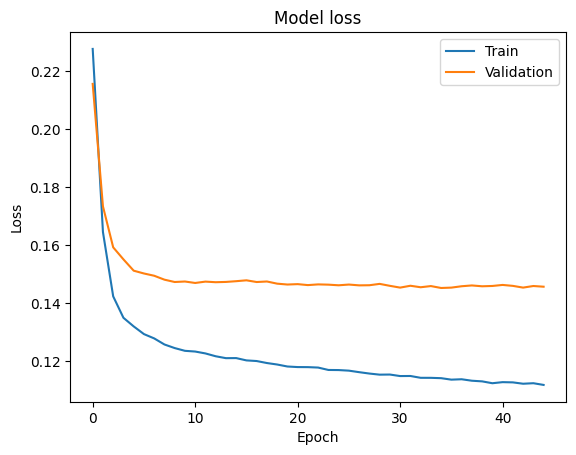

In [82]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Prediction and sMAPE
Performance evaluation of the hybrid GRU-DNN model on the test set.

In [83]:
#Evaluating the model
Yp = model.predict([X_S_test, X_F_test], verbose=0).squeeze()
Yp = y_scaler.inverse_transform(Yp).squeeze()

results = pd.DataFrame({
    'Valori Attesi': Ytest.flatten(),
    'Predizioni': Yp.flatten()
})

print(results.head(20))

# Calculate and print the metrics
smape_value = smape(tf.cast(Ytest, dtype=tf.float64), tf.cast(Yp, dtype=tf.float64))
print(f'sMAPE: {smape_value:.2f}%')

    Valori Attesi  Predizioni
0           25.45   22.652798
1           23.30   23.574898
2           22.23   20.915020
3           20.02   20.001358
4           20.44   21.003889
5           21.87   26.193485
6           34.08   38.436028
7           39.50   52.100128
8           45.59   53.273495
9           43.16   51.730225
10          40.25   49.708694
11          38.08   48.208595
12          32.84   49.719475
13          29.29   45.227325
14          27.72   43.763199
15          27.10   38.342243
16          30.07   38.961445
17          34.47   45.380978
18          48.29   60.840595
19          49.30   60.974266
sMAPE: 19.73%


##CNN model (Convolutional Neural Network)

In [ ]:
activationFunctionCNN = 'relu'
dropoutCNN = 0.31
poolingFrequency = 1
poolingType = 'max'
filterSizePast = 3
filterSizeDA = 3
numberOfConvolutionsPast = 3
numberOfConvolutionsDA = 3
initialFeatureMapsPast = 64
initialFeatureMapsDA = 64
channelLength = 1 #1 weeks
n_hours = 24

hours = range(n_hours)
timesteps = 168 #1 week / hours
firstConvolutionalLayer = 64 #num of feature maps
secondConvolutionalLayer = 128
thirdConvolutionalLayer = 256

The input data are divided into two parts:
*   X_S is a collection of input sequences, each one is a vector representing some sequential past information (as in the previous hybrid models)
*   X_F_col is a collection of input vectors, where each vector represent some future information of the 24 hours of the day ahead



### Y - target

In [ ]:
indexTrain = train_df.iloc[24:,:].loc[train_df.index[0] :].index
indexTest = test_df.iloc[24:,:].loc[test_df.index[0] :].index
indexVal = val_df.iloc[24:,:].loc[val_df.index[0] :].index

predDatesTrain = indexTrain[::24]
predDatesVal = indexVal[::24]
predDatesTest = indexTest[::24]

indexTrain = pd.DataFrame(index=predDatesTrain, columns=['h' + str(hour) for hour in range(24)])
indexVal = pd.DataFrame(index=predDatesVal, columns=['h' + str(hour) for hour in range(24)])
indexTest = pd.DataFrame(index=predDatesTest, columns=['h' + str(hour) for hour in range(24)])

for hour in range(24):
  indexTrain.loc[:, 'h' + str(hour)] = indexTrain.index + pd.Timedelta(hours=hour)
  indexVal.loc[:, 'h' + str(hour)] = indexVal.index + pd.Timedelta(hours=hour)
  indexTest.loc[:, 'h' + str(hour)] = indexTest.index + pd.Timedelta(hours=hour)

# Preallocating in memory the X and Y arrays
Ytrain = np.zeros([indexTrain.shape[0], n_hours])
Yval = np.zeros([indexVal.shape[0], n_hours])
Ytest = np.zeros([indexTest.shape[0], n_hours])

# Extracting the predicted values Y
for hour in range(24):
  futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
  futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
  futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

  Ytrain[:, hour] = train_df.loc[futureIndexTrain, 'Prices']
  Yval[:,hour] = val_df.loc[futureIndexVal, 'Prices']
  Ytest[:, hour] = test_df.loc[futureIndexTest, 'Prices']

# Redefining indexTest to return only the dates at which a prediction is made
indexTest = indexTest.index

In [ ]:
print(Ytrain.shape)
print(Yval.shape)
print(Ytest.shape)

(1542, 24)
(319, 24)
(320, 24)


###X_S - past informations

In [ ]:
#past information (collection of past values)
def create_sequences(data, steps):
    X = []
    for i in range(steps, len(data), n_hours):
      X.append(data.iloc[i-steps:i].values)
    return np.array(X)

# Creazione di X_S per il training, validation e test set
X_S_train = create_sequences(train_df[['Prices']], timesteps) #start after a week: from 16/01/2011
X_S_val = create_sequences(val_df[['Prices']], timesteps)
X_S_test = create_sequences(test_df[['Prices']], timesteps)

print(X_S_train.shape)
print(X_S_val.shape)
print(X_S_test.shape)

(1536, 168, 1)
(313, 168, 1)
(314, 168, 1)


###X_F - day-ahead input
Features:
*   day of the week,
*   24 generation forecast,
*   24 load forecast of the day D.

In [ ]:
def create_sequences_F(data):
    # Extract day of the week and add as a new column
    day_of_week = pd.to_datetime(data.index).dayofweek.to_numpy()

    # Initialize list to hold sequences
    X = []
    for i in range(0, len(data), n_hours):
        day_of_week_window = day_of_week[i:i + n_hours]
        w = data.iloc[i:i+ 24]
        generation = w['Generation forecast'].values
        load = w['System load forecast'].values
        X.append(np.stack([day_of_week_window, generation, load], axis=-1))

    X = np.array(X)  # Shape: (number_of_sequences, n_hours, 3)
    return X

X_F_train = create_sequences_F(train_df[[ 'Generation forecast', 'System load forecast']])
X_F_val = create_sequences_F(val_df[[ 'Generation forecast', 'System load forecast']])
X_F_test = create_sequences_F(test_df[[ 'Generation forecast', 'System load forecast']])

print(X_F_train.shape) #from 09/01/2011
print(X_F_val.shape)
print(X_F_test.shape)

(1543, 24, 3)
(320, 24, 3)
(321, 24, 3)


Data have to be consistent: size and samples have to match

Train start from 16/01/2011

In [ ]:
#same num of samples
Ytrain = Ytrain[6:]   # Remove the first 6 days
Yval = Yval[6:]
Ytest = Ytest[6:]
X_F_train = X_F_train[7:]
X_F_val = X_F_val[7:]
X_F_test = X_F_test[7:]

print(Ytrain.shape)
print(X_F_train.shape)
print(X_S_train.shape)

(1536, 24)
(1536, 24, 3)
(1536, 168, 1)


### Data Normalization

In [ ]:
# Scale X_F
scaler_F = MinMaxScaler(feature_range=(-1, 1))
X_F_train = scaler_F.fit_transform(X_F_train.reshape(-1, X_F_train.shape[2])).reshape(X_F_train.shape)
X_F_val = scaler_F.transform(X_F_val.reshape(-1, X_F_val.shape[2])).reshape(X_F_val.shape)
X_F_test = scaler_F.transform(X_F_test.reshape(-1, X_F_test.shape[2])).reshape(X_F_test.shape)

# Scale X_S
scale_S = MinMaxScaler(feature_range=(-1, 1))
X_S_train = scale_S.fit_transform(X_S_train.reshape(-1, X_S_train.shape[2])).reshape(X_S_train.shape)
X_S_val = scale_S.transform(X_S_val.reshape(-1, X_S_val.shape[2])).reshape(X_S_val.shape)
X_S_test = scale_S.transform(X_S_test.reshape(-1, X_S_test.shape[2])).reshape(X_S_test.shape)

# Scale the target values
y_scaler = MinMaxScaler(feature_range=(-1, 1))
Ytrain = y_scaler.fit_transform(Ytrain)
Yval = y_scaler.transform(Yval)

### Model

In [ ]:
# CNN for past data
inputs = Input(shape=(X_S_train.shape[1], X_S_train.shape[2])) #(timesteps, num_features)
x = inputs

num_feature_maps = firstConvolutionalLayer
for i in range(numberOfConvolutionsPast):
    x = Conv1D(filters=num_feature_maps, kernel_size=filterSizePast, activation=activationFunctionCNN)(x)
    x = MaxPooling1D(pool_size=2)(x) #poolingFrequency = 1 => after every convolutional layer I apply pooling max
    x = BatchNormalization()(x) #apply batch normalization
    x = Dropout(dropoutCNN)(x)  # Add dropout after max pooling and batch normalization
    num_feature_maps *= 2  # Double the number of feature maps (64. 128, 256)

x = Flatten()(x)
past_cnn = Model(inputs, x, name='Past_CNN')



# CNN for day-ahead data
inputs_DA = Input(shape=(X_F_train.shape[1], X_F_train.shape[2])) #(24h, num_features)
xDA = inputs_DA

num_feature_maps = firstConvolutionalLayer
for i in range(numberOfConvolutionsDA):
    xDA = Conv1D(filters=num_feature_maps, kernel_size=filterSizeDA, activation=activationFunctionCNN)(xDA)
    xDA = MaxPooling1D(pool_size=2)(xDA)
    xDA = BatchNormalization()(xDA)
    xDA = Dropout(dropoutCNN)(xDA)  # Add dropout after max pooling and batch normalization
    num_feature_maps *= 2

xDA = Flatten()(xDA)
day_ahead_cnn = Model(inputs_DA, xDA, name='DayAhead_CNN')



# Combine both CNNs
combined = Concatenate(name='concatenate_CNN')([past_cnn.output, day_ahead_cnn.output])

# Fully connected layer after concatenation: Output layer (for day-ahead price prediction)
output = Dense(units = 24, activation='linear')(combined)  # Assuming you want to predict 24-hour prices

# Final model
model = Model(inputs=[past_cnn.input, day_ahead_cnn.input], outputs=output)

# Compile the model
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, loss='mean_absolute_error')

# Model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 168, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 24, 3)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 166, 64)        │            256 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 22, 64)         │            640 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 83, 64)         │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 11, 64)         │              0 │ conv1d_3[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 83, 64)         │            256 │ max_pooling1d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 11, 64)         │            256 │ max_pooling1d_3[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 83, 64)         │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 11, 64)         │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 81, 128)        │         24,704 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 9, 128)         │         24,704 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 40, 128)        │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 4, 128)         │              0 │ conv1d_4[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 40, 128)        │            512 │ max_pooling1d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 373,912 (1.43 MB)

 Trainable params: 372,120 (1.42 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Training CNN model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss',  factor=0.6, patience=8, min_lr=1e-6)

In [ ]:
#train the model
history = model.fit(
    [X_S_train, X_F_train], Ytrain,  # Provide both sequential and non-sequential inputs
    validation_data=([X_S_val, X_F_val], Yval),
    epochs=1000,
    batch_size=96,
    shuffle=True,
    callbacks=[early_stopping, lr_schedule]
)

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step - loss: 1.2219 - val_loss: 0.2801 - learning_rate: 0.0010
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.9953 - val_loss: 0.2738 - learning_rate: 0.0010
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.8672 - val_loss: 0.2967 - learning_rate: 0.0010
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.7568 - val_loss: 0.3097 - learning_rate: 0.0010
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.6927 - val_loss: 0.2661 - learning_rate: 0.0010
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 0.6475 - val_loss: 0.2683 - learning_rate: 0.0010
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 0.6104 - val_loss: 0.2744 - learning_rate: 0.0010
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.5590 - val_loss: 0.2822 - learning_rate: 0.0010
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.5405 - val_loss: 0.2573 - learning_rate

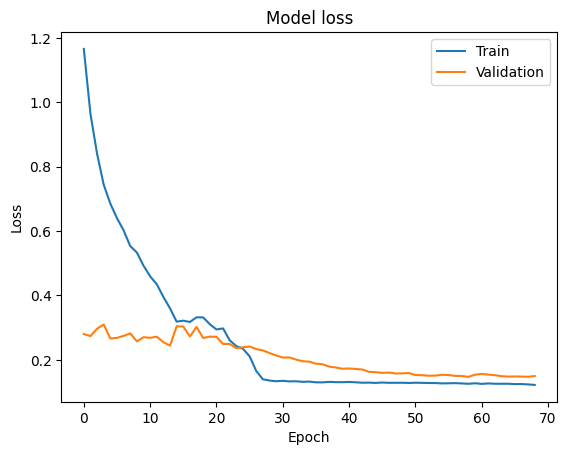

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Prediction and sMAPE
Performance evaluation of the CNN model on the test set

In [ ]:
#Evaluating the model
Yp = model.predict([X_S_test, X_F_test], verbose=0).squeeze()
Yp = y_scaler.inverse_transform(Yp).squeeze()

results = pd.DataFrame({
    'Valori Attesi': Ytest.flatten(),
    'Predizioni': Yp.flatten()
})

print(results.head(20))

# Calculate and print the metrics
smape_value = smape(tf.cast(Ytest, dtype=tf.float64), tf.cast(Yp, dtype=tf.float64))
print(f'sMAPE: {smape_value:.2f}%')

    Valori Attesi  Predizioni
0            7.72   21.814680
1            8.35   20.536585
2            7.15   15.762272
3            4.97   15.650638
4            5.39   15.272997
5            8.38   20.940384
6           18.05   30.140247
7           26.38   42.278038
8           27.92   45.159946
9           31.97   43.945072
10          32.96   41.982899
11          29.76   40.436787
12          27.53   42.953770
13          24.52   41.267273
14          23.98   38.106983
15          23.91   34.791237
16          23.92   35.592606
17          27.93   40.369312
18          40.13   47.278778
19          39.45   48.901955
sMAPE: 21.06%


# BENCHMARK models
*   Statistical methods without exogenous inputs and with exogenous inputs
*   Artificial intelligence models



In [174]:
df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)# Load the dataset
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.columns = df.columns.str.strip()

# Filter the dataset based on the date ranges
train_df = df[(df['Date'] >= start_date) & (df['Date'] < val_start)]
val_df = df[(df['Date'] >= val_start) & (df['Date'] < test_start)]
test_df = df[(df['Date'] >= test_start)]

train_df.set_index('Date', inplace=True)
val_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

##Statistical methods
Statistical methods with or without exogenous inputs

### Box-Cox tranformation
Data Preprocessing for statistical models.

In [122]:
constant = 5.5
train_df_positive = np.maximum(train_df, 0.01)
val_df_positive = np.maximum(val_df, 0.01)#val_df + constant
test_df_positive = np.maximum(test_df, 0.01)

# Function to apply Box-Cox transformation
def apply_boxcox(column):
    transformed, lambda_best_fit = boxcox(column)
    return pd.Series(transformed, name=column.name), lambda_best_fit

# Apply Box-Cox to each column
transformed_results_train = train_df_positive.apply(lambda col: apply_boxcox(col) if pd.api.types.is_numeric_dtype(col) else (col, None))
transformed_results_val = val_df_positive.apply(lambda col: apply_boxcox(col) if pd.api.types.is_numeric_dtype(col) else (col, None))
transformed_results_test = test_df_positive.apply(lambda col: apply_boxcox(col) if pd.api.types.is_numeric_dtype(col) else (col, None))

# Extract transformed data and lambda values
train_df_boxcox = pd.DataFrame({col: result[0] for col, result in transformed_results_train.items() if result[1] is not None})
lambdas_train = {col: result[1] for col, result in transformed_results_train.items() if result[1] is not None}
val_df_boxcox = pd.DataFrame({col: result[0] for col, result in transformed_results_val.items() if result[1] is not None})
lambdas_val = {col: result[1] for col, result in transformed_results_val.items() if result[1] is not None}
test_df_boxcox = pd.DataFrame({col: result[0] for col, result in transformed_results_test.items() if result[1] is not None})
lambdas_test = {col: result[1] for col, result in transformed_results_test.items() if result[1] is not None}

# Display the transformed DataFrame and lambda values
print("Transformed train_df:")
print(train_df_boxcox)
print("\nLambda values for Box-Cox transformation of train df:")
print(lambdas_train)
print("\nTransformed val_df:")
print(val_df_boxcox)
print("\nLambda values for Box-Cox transformation of val df:")
print(lambdas_val)
print("\nTransformed test_df:")
print(test_df_boxcox)
print("\nLambda values for Box-Cox transformation of test df:")
print(lambdas_test)

Transformed train_df:
          Prices  Generation forecast  System load forecast
0      10.566572             3.978823              9.417208
1       8.049175             3.978394              9.367505
2       6.471088             3.977449              9.363816
3       4.847847             3.973998              9.310020
4       4.757044             3.970781              9.277320
...          ...                  ...                   ...
37027  13.823231             3.985891              9.368755
37028  14.493823             3.986264              9.366867
37029  13.687343             3.985647              9.375310
37030  13.353988             3.984164              9.334303
37031  12.344266             3.983859              9.371199

[37032 rows x 3 columns]

Lambda values for Box-Cox transformation of train df:
{'Prices': 0.5516917770598967, 'Generation forecast': -0.2319745795214032, 'System load forecast': -0.029767198208658238}

Transformed val_df:
        Prices  Generation forecas

In [123]:
def smape_stat(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(numerator / denominator) * 100

### fARX
It's a statistical method with exogenous inputs.

Consider: the past prices in Belgium (on days 𝑑−1, 𝑑−2, 𝑑−3 and 𝑑−7), the
day-ahead load forecast in Belgium.

In [124]:
n_features = 24 * len([1, 2, 3, 7]) + 1*24

In [125]:
train_df.index = pd.to_datetime(train_df.index)
val_df.index = pd.to_datetime(val_df.index)
test_df.index = pd.to_datetime(test_df.index)

train_df.index = train_df.index.round('S')
test_df.index = test_df.index.round('S')
val_df.index = val_df.index.round('S')

indexTrain = train_df.iloc[24:,:].loc[train_df.index[0] + pd.Timedelta(weeks=1):].index
indexTest = test_df.iloc[24:,:].loc[test_df.index[0] + pd.Timedelta(weeks=1) :].index
indexVal = val_df.iloc[24:,:].loc[val_df.index[0] + pd.Timedelta(weeks=1):].index

predDatesTrain = indexTrain[::24]
predDatesVal = indexVal[::24]
predDatesTest = indexTest[::24]

# We create dataframe
indexTrain = pd.DataFrame(index=predDatesTrain, columns=['h' + str(hour) for hour in range(24)])
indexVal = pd.DataFrame(index=predDatesVal, columns=['h' + str(hour) for hour in range(24)])
indexTest = pd.DataFrame(index=predDatesTest, columns=['h' + str(hour) for hour in range(24)])

for hour in range(24):
  indexTrain.loc[:, 'h' + str(hour)] = indexTrain.index + pd.Timedelta(hours=hour)
  indexVal.loc[:, 'h' + str(hour)] = indexVal.index + pd.Timedelta(hours=hour)
  indexTest.loc[:, 'h' + str(hour)] = indexTest.index + pd.Timedelta(hours=hour)

# Preallocating in memory the X and Y arrays
Xtrain = np.zeros([indexTrain.shape[0], n_features])
Ytrain = np.zeros([indexTrain.shape[0], n_hours])
Xval = np.zeros([indexVal.shape[0], n_features])
Yval = np.zeros([indexVal.shape[0], n_hours])
Xtest = np.zeros([indexTest.shape[0], n_features])
Ytest = np.zeros([indexTest.shape[0], n_hours])

indexFeatures = 0

# price D-1, D-2, D-3, D-7
for past_day in [1, 2, 3, 7]:
  for hour in range(24): # For each possible horizon
        # We define the corresponding past time indexs
        pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values) - pd.Timedelta(hours=24*past_day)
        pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)  - pd.Timedelta(hours=24*past_day)
        pastIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values) - pd.Timedelta(hours=24*past_day)

        # price D-1
        Xtrain[:, indexFeatures] = train_df.loc[pastIndexTrain, 'Prices']
        Xtest[:, indexFeatures] = test_df.loc[pastIndexTest, 'Prices']
        Xval[:, indexFeatures] = val_df.loc[pastIndexVal, 'Prices']
        indexFeatures += 1


#adding load inputs at day D
for hour in range(24):
    past_day = 1
    #define the corresponding future index at time D
    futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
    futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
    futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

    # Adding Load inputs at day D
    Xtrain[:, indexFeatures] = train_df.loc[futureIndexTrain, 'System load forecast']
    Xval[:, indexFeatures] = val_df.loc[futureIndexVal, 'System load forecast']
    Xtest[:, indexFeatures] = test_df.loc[futureIndexTest, 'System load forecast']
    indexFeatures += 1


# Extracting the predicted values Y
for hour in range(24):
  futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
  futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
  futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

  Ytrain[:, hour] = train_df.loc[futureIndexTrain, 'Prices']
  Yval[:,hour] = val_df.loc[futureIndexVal, 'Prices']
  Ytest[:, hour] = test_df.loc[futureIndexTest, 'Prices']

# Redefining indexTest to return only the dates at which a prediction is made
indexTest = indexTest.index

In [130]:
#fit the model (train)
tol = 1e-6
max_iter = 1000
nmod = 24  # Number of models (one for each hour)

# Convert numpy arrays to DataFrames or Series
Xtrain_df = pd.DataFrame(Xtrain)
Ytrain_df = pd.DataFrame(Ytrain)
Xtest_df = pd.DataFrame(Xtest)
Ytest_df = pd.DataFrame(Ytest)

# Initialize 24 LinearRegression models (one for each hour)
models = [LinearRegression() for _ in range(nmod)]

# Train models for each hour
for hour in range(nmod):
    X_hour = Xtrain_df.iloc[hour::24, :]  # Select features for this specific hour
    y_hour = Ytrain_df.iloc[hour::24, hour]     # Select target for this specific hour

    models[hour].fit(X_hour, y_hour)  # Fit the model for this hour

# Predict on the test set for each hour
predictions = []
for hour in range(nmod):
    X_hour = Xtest_df.iloc[hour::24, :]
    pred_hour = models[hour].predict(X_hour)
    predictions.append(pred_hour)


# Concatenate predictions into a single array
y_pred = np.concatenate(predictions)

# Ensure y_test is correctly aligned for the 24-hour predictions
y_test_aligned = Ytest_df.values.flatten()[:len(y_pred)]  # Match the length of y_test with predictions

In [131]:
# Convert to DataFrames for easier display
df_test = pd.DataFrame({'True Values': y_test_aligned, 'Predicted Values': y_pred})

# Print example rows
print("Examples of true vs predicted values:")
print(df_test.head(20))

# Calculate sMAPE
smape_value = smape_stat(y_test_aligned, y_pred)
print(f'sMAPE: {smape_value:.2f}%')

Examples of true vs predicted values:
    True Values  Predicted Values
0          7.72         13.657873
1          8.35         13.157124
2          7.15         19.008146
3          4.97         22.563189
4          5.39         28.925412
5          8.38         33.540998
6         18.05         43.428658
7         26.38         33.123770
8         27.92         28.964292
9         31.97         27.599567
10        32.96         43.989733
11        29.76         61.369143
12        27.53         74.211712
13        24.52         31.240705
14        23.98         27.898125
15        23.91         25.557716
16        23.92         19.016983
17        27.93         13.246970
18        40.13         19.833341
19        39.45         21.819920
sMAPE: 57.01%


##MACHINE Learning methods


### Multilayer perceptron (MLP)
It's a standard neural netword with a single hidden layer with 117 neurons.



#### Pre-processing data
Its the same of DNN model

In [ ]:
n_features = 1+ 24 + 24 + 24 + 48
print(n_features)

121


In [ ]:
# Define columns #date is the index!
columns = ['Day'] + [f'Price_D-1_h{hour}' for hour in hours] + \
          [f'Price_D-2_h{hour}' for hour in hours] + \
          [f'Price_D-7_h{hour}' for hour in hours] + \
          [f'Generation_D_h{hour}' for hour in hours] + \
          [f'Load_D_h{hour}' for hour in hours]

In [ ]:
train_df.index = pd.to_datetime(train_df.index)
val_df.index = pd.to_datetime(val_df.index)
test_df.index = pd.to_datetime(test_df.index)

train_df.index = train_df.index.round('S')
test_df.index = test_df.index.round('S')
val_df.index = val_df.index.round('S')

In [ ]:
indexTrain = train_df.iloc[24:,:].loc[train_df.index[0] + pd.Timedelta(weeks=1):].index
indexTest = test_df.iloc[24:,:].loc[test_df.index[0] + pd.Timedelta(weeks=1) :].index
indexVal = val_df.iloc[24:,:].loc[val_df.index[0] + pd.Timedelta(weeks=1):].index

print(indexTrain)
predDatesTrain = indexTrain[::24]
predDatesVal = indexVal[::24]
predDatesTest = indexTest[::24]

indexTrain = pd.DataFrame(index=predDatesTrain, columns=['h' + str(hour) for hour in range(24)])
indexVal = pd.DataFrame(index=predDatesVal, columns=['h' + str(hour) for hour in range(24)])
indexTest = pd.DataFrame(index=predDatesTest, columns=['h' + str(hour) for hour in range(24)])

for hour in range(24):
  indexTrain.loc[:, 'h' + str(hour)] = indexTrain.index + pd.Timedelta(hours=hour)
  indexVal.loc[:, 'h' + str(hour)] = indexVal.index + pd.Timedelta(hours=hour)
  indexTest.loc[:, 'h' + str(hour)] = indexTest.index + pd.Timedelta(hours=hour)

Xtrain = np.zeros([indexTrain.shape[0], n_features])
Ytrain = np.zeros([indexTrain.shape[0], n_hours])
Xval = np.zeros([indexVal.shape[0], n_features])
Yval = np.zeros([indexVal.shape[0], n_hours])
Xtest = np.zeros([indexTest.shape[0], n_features])
Ytest = np.zeros([indexTest.shape[0], n_hours])

indexFeatures = 0

Xtrain[:, 0] = indexTrain.index.dayofweek + indexTrain.index.hour / 24
Xval[:, 0] = indexVal.index.dayofweek + indexVal.index.hour / 24
Xtest[:, 0] = indexTest.index.dayofweek
indexFeatures += 1

# price D-1, D-2, D-7
for past_day in [1, 2, 7]:
  for hour in range(24): # For each possible horizon
        # We define the corresponding past time indexs
        pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values) - pd.Timedelta(hours=24*past_day)
        pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)  - pd.Timedelta(hours=24*past_day)
        pastIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values) - pd.Timedelta(hours=24*past_day)

        # price D-1
        Xtrain[:, indexFeatures] = train_df.loc[pastIndexTrain, 'Prices']
        Xtest[:, indexFeatures] = test_df.loc[pastIndexTest, 'Prices']
        Xval[:, indexFeatures] = val_df.loc[pastIndexVal, 'Prices']
        indexFeatures += 1


# Adding generation inputs at day D
for hour in range(24):
    past_day = 1
    #define the corresponding future index at time D
    futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
    futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
    futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

    Xtrain[:, indexFeatures] = train_df.loc[futureIndexTrain, 'Generation forecast']
    Xval[:, indexFeatures] = val_df.loc[futureIndexVal, 'Generation forecast']
    Xtest[:, indexFeatures] = test_df.loc[futureIndexTest, 'Generation forecast']
    indexFeatures += 1


#adding load inputs at day D
for hour in range(24):
    past_day = 1
    #define the corresponding future index at time D
    futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
    futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
    futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

    # Adding Load inputs at day D
    Xtrain[:, indexFeatures] = train_df.loc[futureIndexTrain, 'System load forecast']
    Xval[:, indexFeatures] = val_df.loc[futureIndexVal, 'System load forecast']
    Xtest[:, indexFeatures] = test_df.loc[futureIndexTest, 'System load forecast']
    indexFeatures += 1


DatetimeIndex(['2011-01-16 00:00:00', '2011-01-16 01:00:00',
               '2011-01-16 02:00:00', '2011-01-16 03:00:00',
               '2011-01-16 04:00:00', '2011-01-16 05:00:00',
               '2011-01-16 06:00:00', '2011-01-16 07:00:00',
               '2011-01-16 08:00:00', '2011-01-16 09:00:00',
               ...
               '2015-03-31 14:00:00', '2015-03-31 15:00:00',
               '2015-03-31 16:00:00', '2015-03-31 17:00:00',
               '2015-03-31 18:00:00', '2015-03-31 19:00:00',
               '2015-03-31 20:00:00', '2015-03-31 21:00:00',
               '2015-03-31 22:00:00', '2015-03-31 23:00:00'],
              dtype='datetime64[ns]', name='Date', length=36864, freq=None)


In [ ]:
# Extracting the predicted values Y
for hour in range(24):
  futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
  futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
  futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

  Ytrain[:, hour] = train_df.loc[futureIndexTrain, 'Prices']
  Yval[:,hour] = val_df.loc[futureIndexVal, 'Prices']
  Ytest[:, hour] = test_df.loc[futureIndexTest, 'Prices']

# Redefining indexTest to return only the dates at which a prediction is made
indexTest = indexTest.index

In [ ]:
print(Ytrain)

[[21.32 18.54 14.99 ... 49.32 51.31 46.14]
 [22.73 16.75 17.1  ... 51.24 50.89 48.92]
 [37.65 37.28 34.94 ... 50.01 49.74 45.89]
 ...
 [28.06 24.2  23.07 ... 34.94 30.42 28.37]
 [19.15 23.   22.56 ... 49.33 47.04 43.  ]
 [38.74 26.27 22.68 ... 48.91 47.02 41.5 ]]


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

Xtrain = scaler.fit_transform(Xtrain)
Xval = scaler.transform(Xval)
Xtest = scaler.transform(Xtest)

y_scaler = MinMaxScaler(feature_range=(0, 1))
Ytrain = y_scaler.fit_transform(Ytrain)
Yval = y_scaler.transform(Yval)

In [ ]:
print(Xtrain)

[[1.         0.14302191 0.23694954 ... 0.46666667 0.43313373 0.42454728]
 [0.         0.06322743 0.13480413 ... 0.59122807 0.5508982  0.54124748]
 [0.16666667 0.07061969 0.11925649 ... 0.63333333 0.59481038 0.57746479]
 ...
 [1.         0.21143966 0.35082081 ... 0.34984211 0.29429142 0.29162978]
 [0.         0.09856349 0.18396595 ... 0.41196491 0.35598802 0.33979879]
 [0.16666667 0.05185069 0.17354295 ... 0.42       0.35840319 0.3461167 ]]


#### Model

In [ ]:
# Early stopping configuration and learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
model = Sequential([
    Dense(117, activation='relu', input_shape=(n_features,), kernel_regularizer=regularizers.l1(0.00032)),  # Hidden layer with 117 neurons
    Dense(24)  # Output layer (regression problem; change for classification)
])

# Compile the model with Mean Absolute Error as the Loss function
model.compile(optimizer='adam', loss='mean_absolute_error')  #, metrics=[smape])

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 117)                 │          14,274 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 24)                  │           2,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,106 (66.82 KB)

 Trainable params: 17,106 (66.82 KB)

 Non-trainable params: 0 (0.00 B)

####Training

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6601 - val_loss: 0.4525
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4341 - val_loss: 0.4111
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3897 - val_loss: 0.3789
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3565 - val_loss: 0.3553
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3322 - val_loss: 0.3342
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3110 - val_loss: 0.3144
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2921 - val_loss: 0.2966
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2754 - val_loss: 0.2812
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2608 - val_loss: 0.2672
Epoch 10/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2476 - val_loss: 0.2544
Epoch 11/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2358 - val_loss: 0.2436
Epoch 12/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

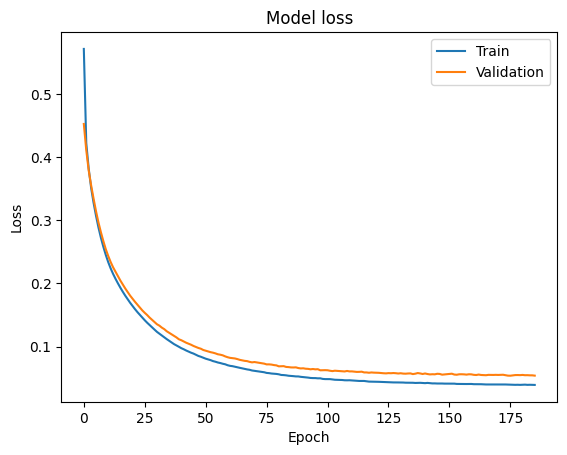

In [ ]:
# Train the model
history = model.fit(Xtrain, Ytrain,
                    epochs=500,
                    batch_size=128,
                    validation_data=(Xval, Yval),
                    shuffle = True,
                    callbacks=[early_stopping])

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### Prediction and sMAPE

In [ ]:
Yp = model.predict(Xtest)
Yp = y_scaler.inverse_transform(Yp)

results = pd.DataFrame({
    'Valori Attesi': Ytest.flatten(),
    'Predizioni': Yp.flatten()
})

print(results.head(20))

# Calculate and print the metrics
smape_value = smape(tf.cast(Ytest, dtype=tf.float64), tf.cast(Yp, dtype=tf.float64))
print(f'sMAPE: {smape_value:.2f}%')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
    Valori Attesi  Predizioni
0            7.72   17.545731
1            8.35   13.170266
2            7.15   11.756234
3            4.97    8.149861
4            5.39    6.290635
5            8.38   10.180699
6           18.05   16.961088
7           26.38   24.572052
8           27.92   40.341217
9           31.97   39.208508
10          32.96   40.108181
11          29.76   41.124790
12          27.53   38.150131
13          24.52   38.694969
14          23.98   36.150513
15          23.91   34.399540
16          23.92   37.290310
17          27.93   43.491573
18          40.13   45.949669
19          39.45   43.867119
sMAPE: 18.48%


###Support Vector Regressor (SVR)
Using the following features:
*  24 lagged prices of the previous day in Belgium.
*  24 lagged prices of one week before in Belgium.
*  The day-ahead grid load forecast in Belgium at prediction hour

In [175]:
n_features = 24 + 24 + 24
print(n_features)

72


In [176]:
# Define columns #date is the index!
columns = [f'Price_D-1_h{hour}' for hour in hours] + \
          [f'Price_D-7_h{hour}' for hour in hours] + \
          [f'Load_D_h{hour}' for hour in hours]

#### Pre-processing data

In [177]:
train_df.index = pd.to_datetime(train_df.index)
val_df.index = pd.to_datetime(val_df.index)
test_df.index = pd.to_datetime(test_df.index)

train_df.index = train_df.index.round('S')
test_df.index = test_df.index.round('S')
val_df.index = val_df.index.round('S')

In [178]:
indexTrain = train_df.iloc[24:,:].loc[train_df.index[0] + pd.Timedelta(weeks=1):].index
indexTest = test_df.iloc[24:,:].loc[test_df.index[0] + pd.Timedelta(weeks=1) :].index
indexVal = val_df.iloc[24:,:].loc[val_df.index[0] + pd.Timedelta(weeks=1):].index

predDatesTrain = indexTrain[::24]
predDatesVal = indexVal[::24]
predDatesTest = indexTest[::24]

indexTrain = pd.DataFrame(index=predDatesTrain, columns=['h' + str(hour) for hour in range(24)])
indexVal = pd.DataFrame(index=predDatesVal, columns=['h' + str(hour) for hour in range(24)])
indexTest = pd.DataFrame(index=predDatesTest, columns=['h' + str(hour) for hour in range(24)])

for hour in range(24):
  indexTrain.loc[:, 'h' + str(hour)] = indexTrain.index + pd.Timedelta(hours=hour)
  indexVal.loc[:, 'h' + str(hour)] = indexVal.index + pd.Timedelta(hours=hour)
  indexTest.loc[:, 'h' + str(hour)] = indexTest.index + pd.Timedelta(hours=hour)

# Preallocating in memory the X and Y arrays
Xtrain = np.zeros([indexTrain.shape[0], n_features])
Ytrain = np.zeros([indexTrain.shape[0], n_hours])
Xval = np.zeros([indexVal.shape[0], n_features])
Yval = np.zeros([indexVal.shape[0], n_hours])
Xtest = np.zeros([indexTest.shape[0], n_features])
Ytest = np.zeros([indexTest.shape[0], n_hours])

indexFeatures = 0

# price D-1, D-7
for past_day in [1, 7]:
  for hour in range(24): # For each possible horizon
        # We define the corresponding past time indexs
        pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values) - pd.Timedelta(hours=24*past_day)
        pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)  - pd.Timedelta(hours=24*past_day)
        pastIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values) - pd.Timedelta(hours=24*past_day)

        # price D-1/7
        Xtrain[:, indexFeatures] = train_df.loc[pastIndexTrain, 'Prices']
        Xtest[:, indexFeatures] = test_df.loc[pastIndexTest, 'Prices']
        Xval[:, indexFeatures] = val_df.loc[pastIndexVal, 'Prices']
        indexFeatures += 1


#adding load inputs at day D
for hour in range(24):
    #define the corresponding future index at time D
    futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
    futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
    futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

    # Adding Load inputs at day D
    Xtrain[:, indexFeatures] = train_df.loc[futureIndexTrain, 'System load forecast']
    Xval[:, indexFeatures] = val_df.loc[futureIndexVal, 'System load forecast']
    Xtest[:, indexFeatures] = test_df.loc[futureIndexTest, 'System load forecast']
    indexFeatures += 1


In [179]:
# Extracting the predicted values Y
for hour in range(24):
  futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
  futureIndexVal = pd.to_datetime(indexVal.loc[:, 'h' + str(hour)].values)
  futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

  Ytrain[:, hour] = train_df.loc[futureIndexTrain, 'Prices']
  Yval[:,hour] = val_df.loc[futureIndexVal, 'Prices']
  Ytest[:, hour] = test_df.loc[futureIndexTest, 'Prices']

# Redefining indexTest to return only the dates at which a prediction is made
indexTest = indexTest.index

In [180]:
#normalize data to [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))

Xtrain = scaler.fit_transform(Xtrain)
Xval = scaler.transform(Xval)
Xtest = scaler.transform(Xtest)

y_scaler = MinMaxScaler(feature_range=(0, 1))
Ytrain = y_scaler.fit_transform(Ytrain)
Yval = y_scaler.transform(Yval)

#### Model, training and prediction

In [181]:
#To consider only the prices and the load on that specific hour!
def select_and_concatenate_columns(matrix, range_end, specific_column_index):
    # Select the first 'range_end' columns
    selected_columns_range = matrix[:, :range_end]

    # Select the specific column
    specific_column = matrix[:, specific_column_index].reshape(-1, 1)

    # Concatenate the selected columns
    concatenated_matrix = np.hstack((selected_columns_range, specific_column))

    return concatenated_matrix

In [182]:
# for storing predictions
Yp = np.zeros_like(Ytest)

C = 9.97  # Penalty parameter
epsilon = 0.0038  # Epsilon

# Train an individual SVR model for each horizon (hour)
for hour in range(n_hours):
    svr_model = SVR(C=C, epsilon=epsilon)
    X = select_and_concatenate_columns(Xtrain, 48, 48+hour)
    svr_model.fit(X, Ytrain[:, hour])     # Train the SVR on the input data for the current hour
    Xt = select_and_concatenate_columns(Xtest, 48, 48+hour)
    Yp[:, hour] = svr_model.predict(Xt)


# Inverse transform the predictions back to the original scale
Yp = y_scaler.inverse_transform(Yp)

results = pd.DataFrame({
    'Valori Attesi': Ytest.flatten(),
    'Predizioni': Yp.flatten()
})

print(results.head(20))

# Calculate and print the metrics
smape_value = smape(tf.cast(Ytest, dtype=tf.float64), tf.cast(Yp, dtype=tf.float64))
print(f'sMAPE: {smape_value:.2f}%')

    Valori Attesi  Predizioni
0            7.72   25.212949
1            8.35   19.775712
2            7.15   15.361842
3            4.97    6.164310
4            5.39    6.219910
5            8.38   13.009758
6           18.05   23.269352
7           26.38    7.626910
8           27.92   42.690111
9           31.97   46.068627
10          32.96   46.453095
11          29.76   50.420986
12          27.53   39.207184
13          24.52   33.889988
14          23.98   32.404092
15          23.91   22.615516
16          23.92   28.254784
17          27.93   51.097158
18          40.13   57.233654
19          39.45   64.502649
sMAPE: 22.02%
